In [1]:
#!/usr/bin/env python3

import tables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
#!pwd

In [3]:
def get_merit_number(muon_energy, angular_error, radius = 600, nevents=100000):
    """
    muon_energy: as np.array
    muon_energy: as np.array
    
    return: a single float value
    """
    cylinder_area = np.pi*radius**2
    val = np.sum(1/(angular_error)**2 * ((muon_energy**(-2)*cylinder_area)/(muon_energy**(-1)*nevents)))
    merit_val = val**(1/2)
    return merit_val

In [4]:
def binned_histogram(xdata, error, bins=11, quant=68, logspace=True):
    """
    input: xdata and the corresponding percentage error. as np.array
    return: return the bin centers, mean and std of in each bin.
    bins : Number of bins. Shoud be an interger not a list. or array.
    """
    if logspace:
        bins = np.logspace(np.log10(np.min(xdata)), np.log10(np.max(xdata)), bins)
    else:
        bins = np.linspace(np.min(xdata), np.max(xdata), bins)
    
    centers = (bins[1:] + bins[:-1]) / 2.0
    lower = centers - bins[:-1]
    upper = bins[1:] - centers
    
    merit_numbers = []
    
    for lower, upper in zip(bins[:-1], bins[1:]):
        cut = (xdata >= lower) & (xdata < upper)
        
        error_distribution = error[cut]
        energy_distribtun = xdata[cut]
        
        merit_number = get_merit_number(energy_distribtun, error_distribution, radius = 600)
        
        merit_numbers.append(merit_number)
    return (
        centers,
        np.array(merit_numbers)
    )

In [5]:
# code from Hans

def zenith_to_dec(zenith):
    dec = -1.*(np.pi/2. - zenith)
    return dec

def GreatCircleDistance(ra_1, dec_1, ra_2, dec_2):
    #Compute the great circle distance between two events#
    #All coordinates must be given in radians#
    delta_dec = np.abs(dec_1 - dec_2)
    delta_ra = np.abs(ra_1 - ra_2)
    x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
        np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
    return 2. * np.arcsin(np.sqrt(x))

## Data preprocessing

In [6]:
f = tables.open_file('data/muon_gun_reco_spline_sim0005_water_fits.hdf5')
#f.root

In [7]:
zenith_true = f.root.MCMuon.col("zenith")
azimuth_true = f.root.MCMuon.col("azimuth")
dec_true = zenith_to_dec(zenith_true)

In [8]:

zenith_reco = f.root.LLHFit_mmsreco.col("zenith")
azimuth_reco = f.root.LLHFit_mmsreco.col("azimuth")
dec_reco = zenith_to_dec(zenith_reco)

In [9]:
dpsi = GreatCircleDistance(azimuth_true, dec_true, azimuth_reco, dec_reco)
print(np.rad2deg(np.percentile(dpsi[np.isfinite(dpsi)], [10, 50, 90])))

[4.45803359e-02 1.07852121e+00 6.42350350e+01]


In [10]:
data_dict = {
    'angular_error_mmsreco': np.degrees(dpsi),
    'muon_energy': f.root.MCMuon.col("energy"),
    'dirTrackLengthA_reco': f.root.LLHFit_mmsrecoDirectHitsA.col("dir_track_length")
}

In [11]:
df = pd.DataFrame(data_dict)
df

,angular_error_mmsreco,muon_energy,dirTrackLengthA_reco
0,0.109332,512903.553092,915.748829
1,83.227653,11354.850029,NaN
2,0.170790,17764.540622,968.139153
3,0.172002,1786.377278,465.954543
4,3.315244,19814.882604,200.199007
...,...,...,...
293184,120.540935,52549.088219,NaN
293185,0.017255,507285.577759,879.021947
293186,26.426626,186959.461117,NaN
293187,NaN,2823.378348,NaN


In [12]:
# checking for NaN values
print(df.isnull().sum())

angular_error_mmsreco     8715
muon_energy                  0
dirTrackLengthA_reco     33675
dtype: int64


In [13]:
df = df.dropna()
df

,angular_error_mmsreco,muon_energy,dirTrackLengthA_reco
0,0.109332,512903.553092,915.748829
2,0.170790,17764.540622,968.139153
3,0.172002,1786.377278,465.954543
4,3.315244,19814.882604,200.199007
5,0.011252,213786.235387,980.957370
...,...,...,...
293181,0.034643,237624.620391,951.753038
293182,53.677076,5413.821422,86.607289
293183,0.099085,400185.205235,638.132060
293185,0.017255,507285.577759,879.021947


In [14]:
get_merit_number(df.muon_energy, df.angular_error_mmsreco)

171.97478000133137

In [15]:
log_bin, merit_number = binned_histogram(xdata = df.muon_energy,
                                         error=df.angular_error_mmsreco, 
                                         bins=11, 
                                         quant=68,
                                         logspace=True)

In [16]:
len(log_bin)

10

In [17]:
len(merit_number)

10

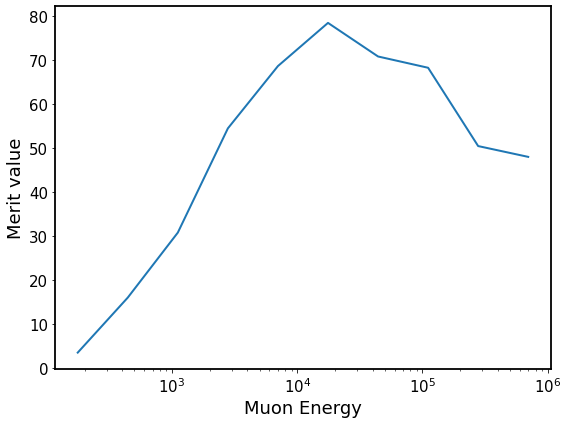

In [18]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(log_bin, merit_number, lw=2)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.8)
    ax.spines[axis].set_color('0.0')
    ax.spines[axis].set_linewidth(1.8)
    ax.spines[axis].set_color('0.0')

ax.set_xlabel("Muon Energy", fontsize=18)
ax.set_ylabel("Merit value", fontsize=18)
    
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

ax.set_xscale('log')
plt.tight_layout()
plt.show()

## Plotting per track length

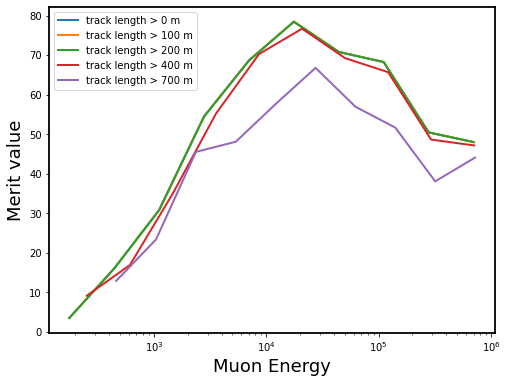

In [19]:
fig, ax = plt.subplots(figsize=(8,6))

for LDir in [0, 100, 200, 400, 700]:
    data = df.loc[(df['dirTrackLengthA_reco'] > LDir)]
    muon_energy = data.muon_energy
    
    angular_error_mmsreco = data.angular_error_mmsreco
    
    log_bin, merit_number = binned_histogram(xdata = muon_energy,
                                         error = angular_error_mmsreco, 
                                         bins = 11, 
                                         quant = 68,
                                         logspace = True)

    ax.plot(log_bin, merit_number, label = f'track length > {LDir} m', lw=2)
    
    ax.set_xlabel("Muon Energy", fontsize=18)
    ax.set_ylabel("Merit value", fontsize=18)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.8)
        ax.spines[axis].set_color('0.0')
        ax.spines[axis].set_linewidth(1.8)
        ax.spines[axis].set_color('0.0')
    
    ax.set_xscale('log')
    ax.legend()
plt.show()